In [2]:
from google.colab import files
uploaded = files.upload()

Saving DataSet.csv to DataSet.csv


In [3]:
import pandas as pd

# Load dataset
df = pd.read_csv("DataSet.csv", low_memory=False)

# Drop columns with too many missing values
threshold = len(df) * 0.4
df_cleaned = df.dropna(thresh=threshold, axis=1)

# Fill missing values
for col in df_cleaned.columns:
    if df_cleaned[col].dtype in ['float64', 'int64']:
        df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())
    else:
        df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])

# Extract datetime features
datetime_cols = [col for col in df_cleaned.columns if 'time' in col.lower() or 'date' in col.lower()]
for col in datetime_cols:
    try:
        df_cleaned[col] = pd.to_datetime(df_cleaned[col], errors='coerce')
        df_cleaned[f"{col}_hour"] = df_cleaned[col].dt.hour
        df_cleaned[f"{col}_day"] = df_cleaned[col].dt.dayofweek
    except Exception as e:
        print(f"Skipping column '{col}': {e}")

# Encode categorical features
df_encoded = pd.get_dummies(df_cleaned, drop_first=True)
df_encoded.to_csv("Processed_DataSet.csv", index=False)

print("✅ Preprocessing Complete")

✅ Preprocessing Complete


In [4]:
# Show all energy usage related columns
kw_columns = [col for col in df.columns if '[kW]' in col]
print("Available [kW] columns:")
for col in kw_columns:
    print(f" - {col}")


Available [kW] columns:
 - use [kW]
 - gen [kW]
 - House overall [kW]
 - Dishwasher [kW]
 - AC 1 [kW]
 - AC 2 [kW]
 - Home office [kW]
 - Fridge [kW]
 - Bed Room [kW]
 - Light 3 [kW]
 - Light 1 [kW]
 - Light 2 [kW]
 - Furnace [kW]
 - Microwave [kW]
 - Living room [kW]
 - Solar [kW]


Model                R² Score   MSE        RMSE       MAE       
-------------------------------------------------------
Linear               0.1668     0.0048   0.0691   0.0546
Decision Tree        0.6814     0.0018   0.0427   0.0083
Random Forest        0.8745     0.0007   0.0268   0.0070
Gradient Boosting    0.7845     0.0012   0.0351   0.0122
SVR                  -0.3896     0.0080   0.0892   0.0715


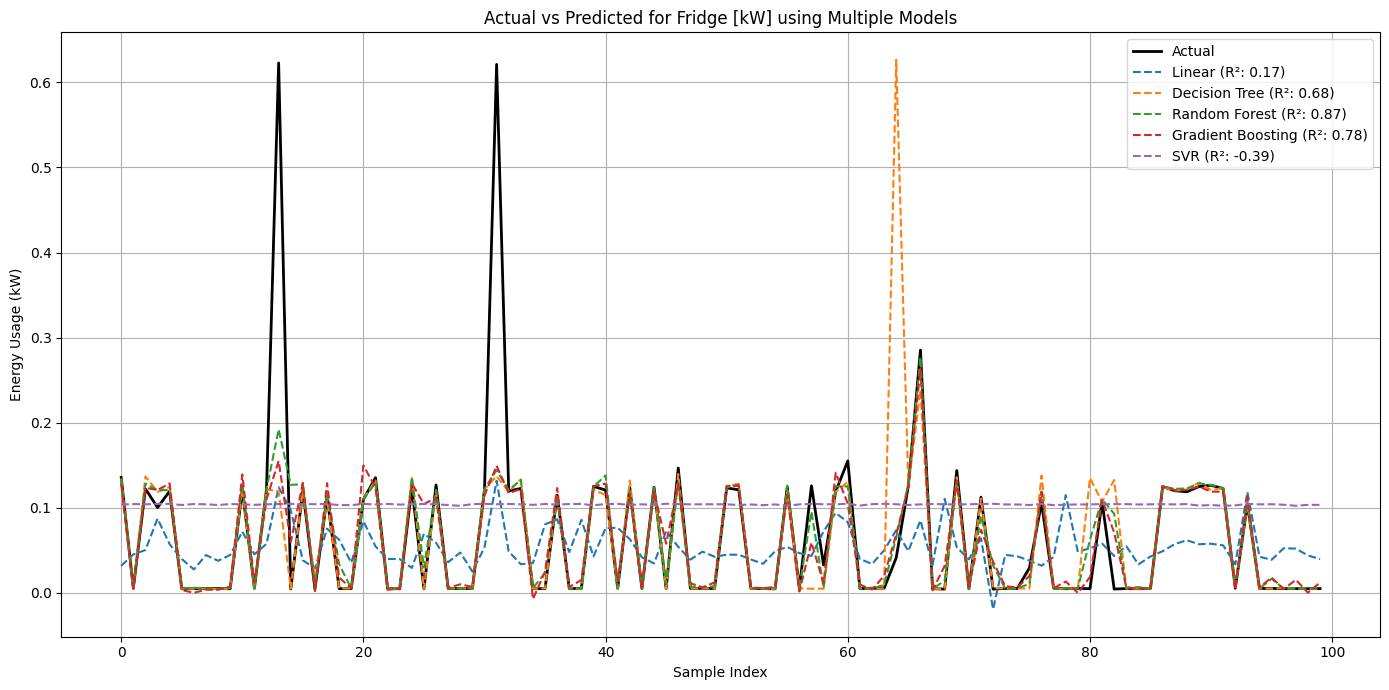

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("Processed_DataSet.csv")

# Extract time features
df['time'] = pd.to_datetime(df['time'], errors='coerce')
df['hour'] = df['time'].dt.hour
df['day'] = df['time'].dt.dayofweek

# Choose one appliance
target = 'Fridge [kW]'

# Prepare X and y
df = df.drop(columns=['time', 'date'], errors='ignore')
X = df.drop(columns=[target])
X = X.select_dtypes(include=['float64', 'int64'])
y = df[target]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Linear": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "SVR": SVR()
}

# Evaluate and store results
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    results.append((name, r2, mse, rmse, mae))

# Print results
print(f"{'Model':<20} {'R² Score':<10} {'MSE':<10} {'RMSE':<10} {'MAE':<10}")
print("-" * 55)
for name, r2, mse, rmse, mae in results:
    print(f"{name:<20} {r2:.4f}     {mse:.4f}   {rmse:.4f}   {mae:.4f}")

# Plot setup
plt.figure(figsize=(14, 7))
plt.plot(y_test.values[:100], label='Actual', color='black', linewidth=2)

# Predict and plot for each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    plt.plot(y_pred[:100], label=f"{name} (R²: {r2:.2f})", linestyle='--')

plt.title(f"Actual vs Predicted for {target} using Multiple Models")
plt.xlabel("Sample Index")
plt.ylabel("Energy Usage (kW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
from sklearn.multioutput import MultiOutputRegressor
# Pick best model by R² (or lowest MAE/RMSE)
best_model_name, *_ = sorted(results, key=lambda x: (-x[1], x[4]))[0]
print(f"\n✅ Best model selected: {best_model_name}")

# Retrain best model on all appliance targets
from sklearn.base import clone
best_model = clone(models[best_model_name])

# Identify appliance columns (excluding totals, gen, etc.)
appliance_targets = [col for col in df.columns if '[kW]' in col and 'use' not in col.lower()
                     and 'overall' not in col.lower() and 'solar' not in col.lower()
                     and 'gen' not in col.lower()]

X_full = df.drop(columns=appliance_targets)
X_full = X_full.select_dtypes(include=['float64', 'int64'])
Y_full = df[appliance_targets]

# Split
X_train, X_test, y_train, y_test = train_test_split(X_full, Y_full, test_size=0.2, random_state=42)

# Train
multi_model = MultiOutputRegressor(best_model)
multi_model.fit(X_train, y_train)

# Predict and evaluate each appliance
print("\n🔌 Appliance-wise performance using best model:")
for i, appliance in enumerate(appliance_targets):
    y_pred = multi_model.predict(X_test)[:, i]
    r2 = r2_score(y_test[appliance], y_pred)
    mae = mean_absolute_error(y_test[appliance], y_pred)
    print(f"{appliance:<25} R²: {r2:.4f}   MAE: {mae:.4f}")



✅ Best model selected: Random Forest

🔌 Appliance-wise performance using best model:
Dishwasher [kW]           R²: 0.8949   MAE: 0.0115
AC 1 [kW]                 R²: 0.7157   MAE: 0.0698
AC 2 [kW]                 R²: 0.7627   MAE: 0.0632
Home office [kW]          R²: 0.9415   MAE: 0.0087
Fridge [kW]               R²: 0.6667   MAE: 0.0217
Bed Room [kW]             R²: 0.1381   MAE: 0.0010
Light 3 [kW]              R²: -1.2818   MAE: 0.0001
Light 1 [kW]              R²: 0.3830   MAE: 0.0122
Light 2 [kW]              R²: -0.1429   MAE: 0.0000
Furnace [kW]              R²: 0.9213   MAE: 0.0117
Microwave [kW]            R²: 0.4014   MAE: 0.0083
Living room [kW]          R²: 0.8715   MAE: 0.0093


In [12]:
from datetime import datetime

# --- USER INPUT SECTION ---
user_time_str = input("\n⏰ Enter the timestamp (e.g., 2016-01-01 14:00:00): ")
appliance_input = input("🔌 Enter the appliance name (e.g., Fridge [kW]): ")

# Convert time to datetime
try:
    user_time = pd.to_datetime(user_time_str)
    user_hour = user_time.hour
    user_day = user_time.dayofweek
except:
    print("❌ Invalid timestamp format. Use 'YYYY-MM-DD HH:MM:SS'")
    exit()

# Validate appliance
if appliance_input not in appliance_targets:
    print(f"❌ Appliance '{appliance_input}' not found in appliance columns.")
    print("Available appliances:")
    for a in appliance_targets:
        print(" -", a)
    exit()

# Prepare prediction input
input_data = X_full.median().to_dict()  # Use median values for all other features
input_data['hour'] = user_hour
input_data['day'] = user_day

# Align with training feature order
sample_input = pd.DataFrame([input_data])[X_full.columns]

# Predict
predicted_value = multi_model.predict(sample_input)[0][appliance_targets.index(appliance_input)]
print(f"\n✅ Predicted usage for '{appliance_input}' at {user_time_str}: {predicted_value:.4f} kW")


KeyboardInterrupt: Interrupted by user

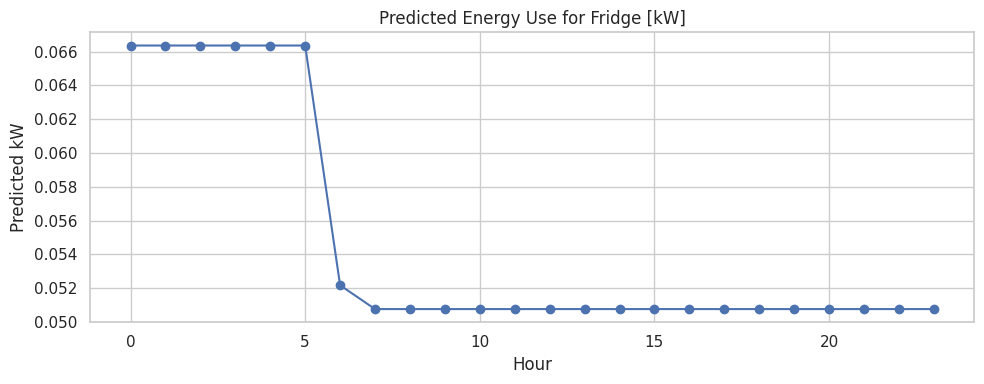

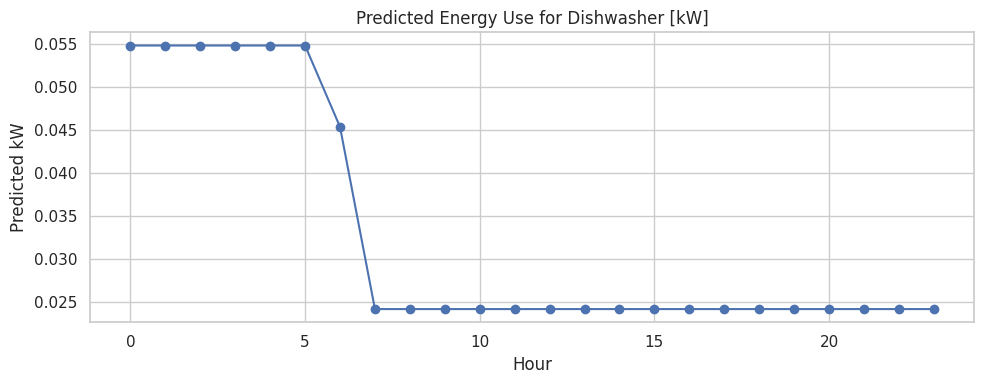

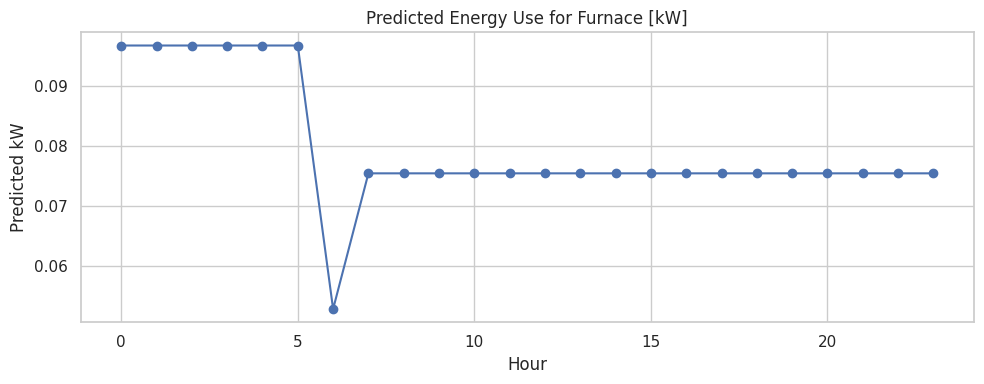

🔁 Recommended usage times for high-power appliances:
- Fridge [kW]: use at hours [7, 8, 9]
- Dishwasher [kW]: use at hours [7, 8, 9]
- Furnace [kW]: use at hours [6, 7, 8]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Load dataset
df = pd.read_csv("DataSet.csv")
df['time'] = pd.to_datetime(df['time'], errors='coerce')
df['hour'] = df['time'].dt.hour
df['day'] = df['time'].dt.dayofweek

# Target appliances
appliances = ['Fridge [kW]', 'Dishwasher [kW]', 'Furnace [kW]']
df = df.dropna(subset=appliances)

# Prepare training data
X = df[['hour', 'day']]
recommendations = {}

# Loop through each appliance and predict hourly usage
for appliance in appliances:
    y = df[appliance]
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    # Predict energy for every hour of the day
    forecast_data = pd.DataFrame({'hour': range(24), 'day': [0]*24})  # assuming Monday
    preds = model.predict(forecast_data)

    # Store results
    forecast_data[appliance] = preds
    low_hours = forecast_data.nsmallest(3, appliance)['hour'].tolist()
    recommendations[appliance] = low_hours

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(forecast_data['hour'], preds, marker='o')
    plt.title(f"Predicted Energy Use for {appliance}")
    plt.xlabel("Hour")
    plt.ylabel("Predicted kW")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Print recommended hours
print("🔁 Recommended usage times for high-power appliances:")
for appliance, hours in recommendations.items():
    print(f"- {appliance}: use at hours {hours}")


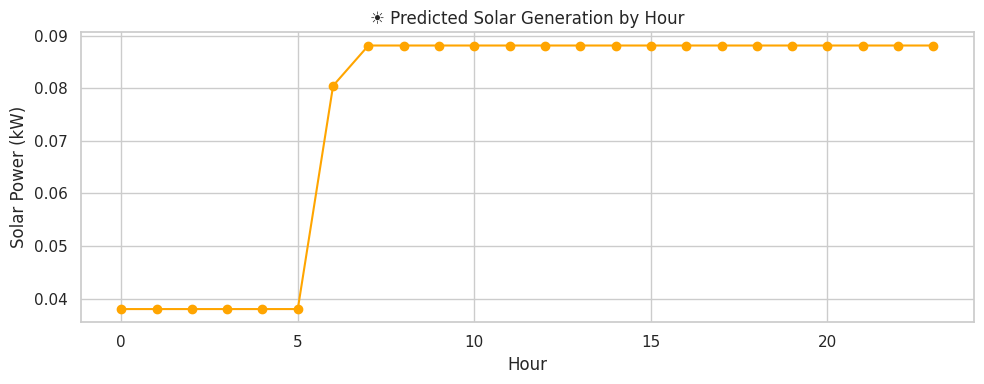

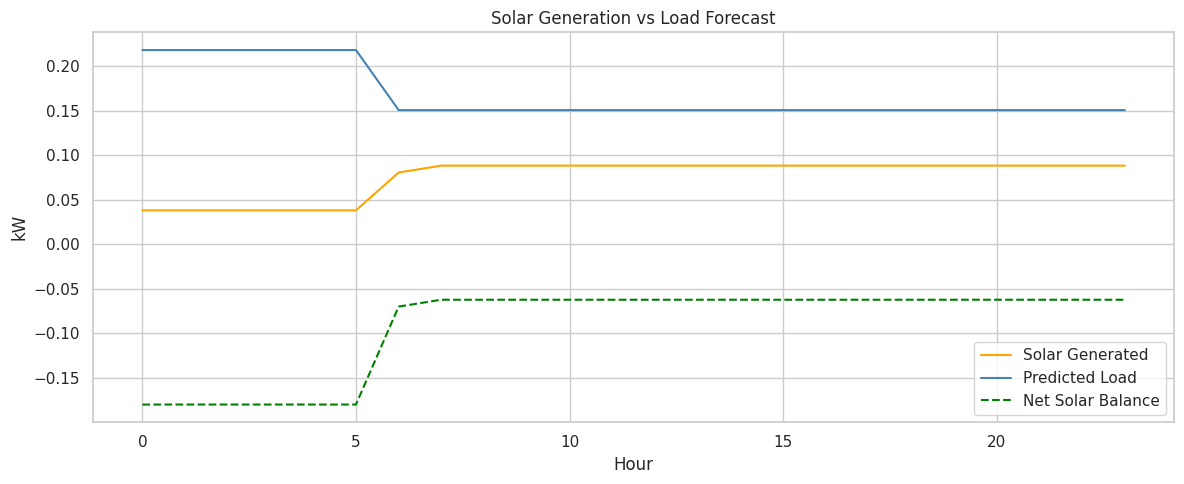

⚡ Recommended load shifting hours based on solar availability: []


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Load dataset
df = pd.read_csv("DataSet.csv", low_memory=False)
df['time'] = pd.to_datetime(df['time'], errors='coerce')
df['hour'] = df['time'].dt.hour
df['day'] = df['time'].dt.dayofweek
df['month'] = df['time'].dt.month

# Required columns
required_cols = ['Solar [kW]', 'use [kW]', 'Fridge [kW]', 'Dishwasher [kW]', 'Furnace [kW]' ]
df = df.dropna(subset=required_cols)

# Predict solar output using time features
solar_model = RandomForestRegressor(n_estimators=100, random_state=42)
X_solar = df[['hour', 'day', 'month']]
y_solar = df['Solar [kW]']
solar_model.fit(X_solar, y_solar)

# Predict solar generation for all 24 hours (Monday, July)
solar_forecast = pd.DataFrame({'hour': range(24), 'day': [0]*24, 'month': [7]*24})
solar_pred = solar_model.predict(solar_forecast)
solar_forecast['Solar [kW]'] = solar_pred

plt.figure(figsize=(10, 4))
plt.plot(solar_forecast['hour'], solar_forecast['Solar [kW]'], marker='o', color='orange')
plt.title("☀️ Predicted Solar Generation by Hour")
plt.xlabel("Hour")
plt.ylabel("Solar Power (kW)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Predict usage of high-load appliances by hour
appliances = ['Fridge [kW]', 'Dishwasher [kW]', 'Furnace [kW]']
appliance_models = {}
X_time = df[['hour', 'day', 'month']]
hourly_data = pd.DataFrame({'hour': range(24), 'day': [0]*24, 'month': [7]*24})

for app in appliances:
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_time, df[app])
    hourly_data[app] = model.predict(hourly_data[['hour', 'day', 'month']])
    appliance_models[app] = model


# Merge appliance predictions and solar forecast
hourly_data['Solar [kW]'] = solar_pred
hourly_data['Total Usage [kW]'] = hourly_data[appliances].sum(axis=1)
hourly_data['Net Solar Balance [kW]'] = hourly_data['Solar [kW]'] - hourly_data['Total Usage [kW]']

plt.figure(figsize=(12, 5))
plt.plot(hourly_data['hour'], hourly_data['Solar [kW]'], label='Solar Generated', color='orange')
plt.plot(hourly_data['hour'], hourly_data['Total Usage [kW]'], label='Predicted Load', color='steelblue')
plt.plot(hourly_data['hour'], hourly_data['Net Solar Balance [kW]'], label='Net Solar Balance', linestyle='--', color='green')
plt.title("Solar Generation vs Load Forecast")
plt.xlabel("Hour")
plt.ylabel("kW")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Recommend hours with positive net solar balance
recommended_hours = hourly_data[hourly_data['Net Solar Balance [kW]'] > 0]['hour'].tolist()
print("⚡ Recommended load shifting hours based on solar availability:", recommended_hours)
